# Reinforcement Learning

**Grid World environment with DQN**

\- Vaibhav Rao
  50375332

\- Kunal Beniwal
  50381672



In [1]:
! pip install gym

#### Imports

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.optimizers import Adam
from collections import deque

In [45]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self):
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 20
        
    def reset(self):
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [3, 3]
        self.trap = [2, 0]
        self.food = [1,2]
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.trap)] = 0.3
        self.state[tuple(self.food)] = 0.1
        #observation = self.state.flatten()
        observation = self.agent_pos[0]*4 + self.agent_pos[1]
        return observation
    
    def step(self, action):
        self.prev_state = list(self.agent_pos)
        # Move DOWN
        if action == 0:
          self.agent_pos[0] += 1
        # Move UP
        if action == 1:
          self.agent_pos[0] -= 1
        # Move Right
        if action == 2:
          self.agent_pos[1] += 1
        # Move Left
        if action == 3:
          self.agent_pos[1] -= 1
          
        self.agent_pos = np.clip(self.agent_pos, 0, 3)
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.trap)] = 0.3
        self.state[tuple(self.food)] = 0.1
        # observation = self.state.flatten()
        observation = self.agent_pos[0]*4 + self.agent_pos[1]
        
        reward = 0
        if (self.agent_pos == self.goal_pos).all():
          reward = 30
        if (self.agent_pos == self.trap).all():
          reward = -5
        if (self.agent_pos == self.food).all():
          reward = 2
        if (self.agent_pos == self.prev_state).all():
          reward = -1
        
        
        self.timestep += 1
        done = True if self.timestep >= self.max_timesteps else False
        info = {}
        
        return observation, reward, done, info

    def step_stochastic(self, action):
        self.prev_state = list(self.agent_pos)
        self.same_pos_reward = True
        # Move DOWN (Stochastic with 0.1 probability of not moving)
        if action == 0:
          stoch_step = np.random.choice([1, 0], p=[0.9,0.1])
          self.agent_pos[0] += stoch_step
          if not stoch_step:
            self.same_pos_reward = False
        # Move UP
        if action == 1:
          self.agent_pos[0] -= 1
        # Move Right
        if action == 2:
          self.agent_pos[1] += 1
        # Move Left (Probability of not taking a left in this action = 0.3)
        if action == 3:
          stoch_step = np.random.choice([1, 0], p=[0.7,0.3])
          self.agent_pos[1] -= stoch_step
          if not stoch_step:
            self.same_pos_reward = False

        self.agent_pos = np.clip(self.agent_pos, 0, 3)
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.trap)] = 0.3
        self.state[tuple(self.food)] = 0.1
        # observation = self.state.flatten()
        observation = self.agent_pos[0]*4 + self.agent_pos[1]
        
        reward = 0
        if (self.agent_pos == self.goal_pos).all():
          reward = 10
        if (self.agent_pos == self.trap).all():
          reward = -5
        if (self.agent_pos == self.food).all():
          reward = 2
        if (self.agent_pos == self.prev_state).all() and self.same_pos_reward:
          reward = -1
        
        
        self.timestep += 1
        done = True if self.timestep >= self.max_timesteps else False
        info = {}
        
        return observation, reward, done, info

    def render(self):
        plt.imshow(self.state)

    def run(self, agent):
      state = self.reset()
      self.R=0
      while True:            
        self.render()
        action = agent.act(state)
        nextState, reward, done, info = self.step(action)
        if done: # terminal state
            nextState = None
        agent.remember(state, action, reward, nextState, done)
        agent.replay(32)

        state = nextState
        self.R = self.R + reward

        if done:
            break

      print("Total reward:", self.R)
      return self.R


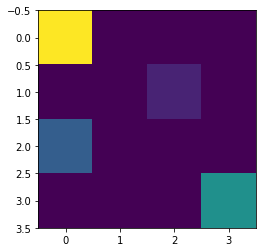

In [14]:
env = GridEnvironment()
obs = env.reset()
env.render()

In [98]:
class Agent():
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space.n
    self.action_space = env.action_space.n
    self.model = self.buildModel()
    self.memory = deque(maxlen=1500)
    self.lr = 0.001
    self.gamma = 0.95
    self.epsilon = 1.0

  def buildModel(self):
    model = Sequential()
    model.add(Dense(24, input_shape=(self.observation_space,), activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(self.action_space, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

  def predictState(self, state):
    #print("pred",state)
    #s = np.zeros((self.observation_space,), dtype=int)
    #s[int(state)]=1
    print("Predict Shape :",state.shape)
    return self.model.predict(state,)

  def act(self, state):
    print("act",state)
    s = np.zeros((self.observation_space,1), dtype=int)
    s[state]=1
    print("act",state)
    if np.random.uniform(0,1) <= self.epsilon:
      return np.random.choice(self.action_space)
    else:
      return np.argmax(self.predictState(s))

  def sample(self,n):
    n = min(n, len(self.memory))
    return random.sample(self.memory, n)

  def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))
    if self.epsilon > 0.1:
        self.epsilon *= 0.9
    return self.epsilon
    

  def replay(self, batch_size):
    if len(self.memory) < batch_size:
      return
    sample_batch = random.sample(self.memory, batch_size)
    for state, action, reward, next_state, done in sample_batch:
        target = reward
        if not done:
          print("replay",next_state)
          target = reward + self.gamma * np.amax(self.model.predict(next_state))
        print("replay",next_state)
        target_f = self.model.predict(state)
        target_f[action] = target
        self.model.fit(state, target_f, epochs=1, verbose=0)


act 0
act 0
act 0
act 0
act 1
act 1
act 5
act 5
act 9
act 9
Predict Shape : (16, 1)


ValueError: ignored

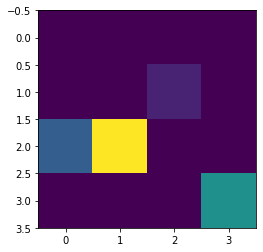

In [99]:
env = GridEnvironment()

states  = env.observation_space.n
actions = env.action_space.n
agent = Agent(env)

episodes=2000
for i in range(episodes):
    r = env.run(agent)
    reward.append(r)
